# Visualizing The Fitting Parameters
We needed some sort of a metric to distinguish between the intensity v SDD curves for different model parameter combinations. The obvious choice was MSE. But MSE does not preserve any sense of the shape of the curve. Common metrics would be Frechet Distance(A person walking a dog, the trajectories of both are the curves, the max leash length), Hausdorf distance(The max. distance between any two points of both curves).  

None of those seemed useful for our case. Perhaps the best metric might be the fitting params. In this notebook, we explore how these fitting params change with different model parameters and if it truely is a good distance metric.  
(Beware, the data fitting is slow)

In [14]:
import seaborn as sns
from inverse_modelling_tfo.data import get_interpolate_fit_params, get_interpolate_fit_params_custom, equidistance_detector_normalization
from inverse_modelling_tfo.data.intensity_interpolation import _generate_weights_log
import matplotlib.pyplot as plt
from matplotlib import ticker
import numpy as np
import pandas as pd


# Load Data
# data = pd.read_pickle(r'/home/rraiyan/personal_projects/tfo_inverse_modelling/data/intensity/test_data.pkl')
# data = pd.read_pickle(r'/home/rraiyan/personal_projects/tfo_inverse_modelling/data/intensity/intensity_summed_sim_data.pkl')
# data = pd.read_pickle(r'/home/rraiyan/personal_projects/tfo_inverse_modelling/data/intensity/intensity_averaged_sim_data.pkl')
data = pd.read_pickle(r'/home/rraiyan/personal_projects/tfo_inverse_modelling/data/intensity/intensity_summed_sim_data_equidistance_detector_extended.pkl')
# Normalize intensity
equidistance_detector_normalization(data)
print(len(data))    # Length sanity check
# data = normalize_zero_mean(data)
data.head(10)

63840


,SDD,Intensity,Wave Int,Uterus Thickness,Maternal Wall Thickness,Maternal Mu_a,Fetal Mu_a
0,10,1.812894e-04,2.0,5.0,26.0,0.005,0.05
1,14,3.681103e-05,2.0,5.0,26.0,0.005,0.05
2,19,8.854552e-06,2.0,5.0,26.0,0.005,0.05
3,23,2.952029e-06,2.0,5.0,26.0,0.005,0.05
4,28,1.092797e-06,2.0,5.0,26.0,0.005,0.05
5,32,4.277922e-07,2.0,5.0,26.0,0.005,0.05
6,37,1.715046e-07,2.0,5.0,26.0,0.005,0.05
7,41,7.471047e-08,2.0,5.0,26.0,0.005,0.05
8,46,3.120305e-08,2.0,5.0,26.0,0.005,0.05
9,50,1.365238e-08,2.0,5.0,26.0,0.005,0.05


In [15]:
def custom_fit_eqn(data, weights):
    input_sdd = data['SDD'].to_numpy()
    input_sdd = np.append([0.0], input_sdd)

    input_y = data['Intensity'].to_numpy()
    input_y = np.append([1], input_y)

    x = np.ones((len(input_sdd), 3))  # One column for SDD and one for the bias
    x[:, 0] = input_sdd
    x[:, 1] = np.sqrt(input_sdd)
    x[:, 2] = np.power(input_sdd, 1/3)
    Y = np.log10(input_y).reshape(-1, 1)

    # Normalize By Max
    x[:, :] /= np.max(x[:, :], axis=0)
    # Normalize to be between 0 and -1
    Y_MULTIPLIER = 1
    Y /= Y_MULTIPLIER


    # W = np.diag(np.linspace(1, 0.05, num=20))   # Define the weight
    # W = np.diag(np.logspace(1, -3, num=20))   # Define the weight
    W = np.diag(_generate_weights_log(weights, (x[0, 0], x[-1, 0]), x[:, 0]))
    beta_hat = np.linalg.inv(x.T @ W @ x) @ x.T @ W @ Y # Solve
    return beta_hat

In [16]:
# custom_fit_eqn(data.iloc[:20, :], [0, 0])   # Fit only 1 set of data (DEBUG PURPOSES)

(3, 1)


In [4]:
# fitting_param_table = get_interpolate_fit_params(data, weights=[1, 0.5])
fitting_param_table = get_interpolate_fit_params_custom(data, custom_fit_eqn, weights=[0, 1])
print(len(fitting_param_table))    # Length sanity check
print(fitting_param_table.head())


3192
   Wave Int  Uterus Thickness  Maternal Wall Thickness  Maternal Mu_a  \
0       2.0               5.0                     26.0          0.005   
1       2.0               5.0                     26.0          0.009   
2       2.0               5.0                     26.0          0.013   
3       2.0               5.0                     26.0          0.017   
4       2.0               5.0                     26.0          0.021   

   Fetal Mu_a     alpha0    alpha1     alpha2  
0        0.05  -6.425911  6.368115 -11.253845  
1        0.05  -7.315468  4.344254  -9.824272  
2        0.05  -8.247370  3.089932  -8.899700  
3        0.05  -9.317111  2.614853  -8.481814  
4        0.05 -10.603633  2.976562  -8.600288  


## How Does The Fitting Parameters Stack up?
What is the distribtuion of the fitting parameters under this scheme

In [13]:
fitting_params_columns = fitting_param_table[list(filter(lambda X: 'alpha' in X, fitting_param_table.columns))]
fitting_params_columns.describe()

,alpha0,alpha1,alpha2
count,3192.000000,3192.000000,3192.000000
mean,-2.001246,-18.234917,4.224723
std,12.959149,29.290894,17.834785
min,-31.463265,-96.444682,-30.058974
25%,-11.345067,-42.926040,-9.690313
50%,-5.788317,-3.661760,-4.239918
75%,9.149542,4.398737,19.215290
max,27.842386,38.128436,52.533388


In [5]:
fitting_param_count = len(list(filter(lambda X: 'alpha' in X, fitting_param_table.columns)))

In [6]:
parameter_names = ['Maternal Mu_a', 'Fetal Mu_a', 'Maternal Wall Thickness', 'Uterus Thickness']
for parameter in parameter_names:
    print(parameter, ' unique values ', pd.unique(data[parameter]))

Maternal Mu_a  unique values  [0.005 0.009 0.013 0.017 0.021 0.025 0.029 0.033 0.037 0.041 0.045 0.049]
Fetal Mu_a  unique values  [0.05 0.09 0.13 0.17 0.21 0.25 0.29]
Maternal Wall Thickness  unique values  [26. 30. 14.  6. 12. 36. 20. 10. 38. 28.  2. 22. 18. 24. 16.  4.  8. 34.
 32.]
Uterus Thickness  unique values  [5.]


# Changes in Fitting Parameter with Degrees of Freedom(Wavelength 1)

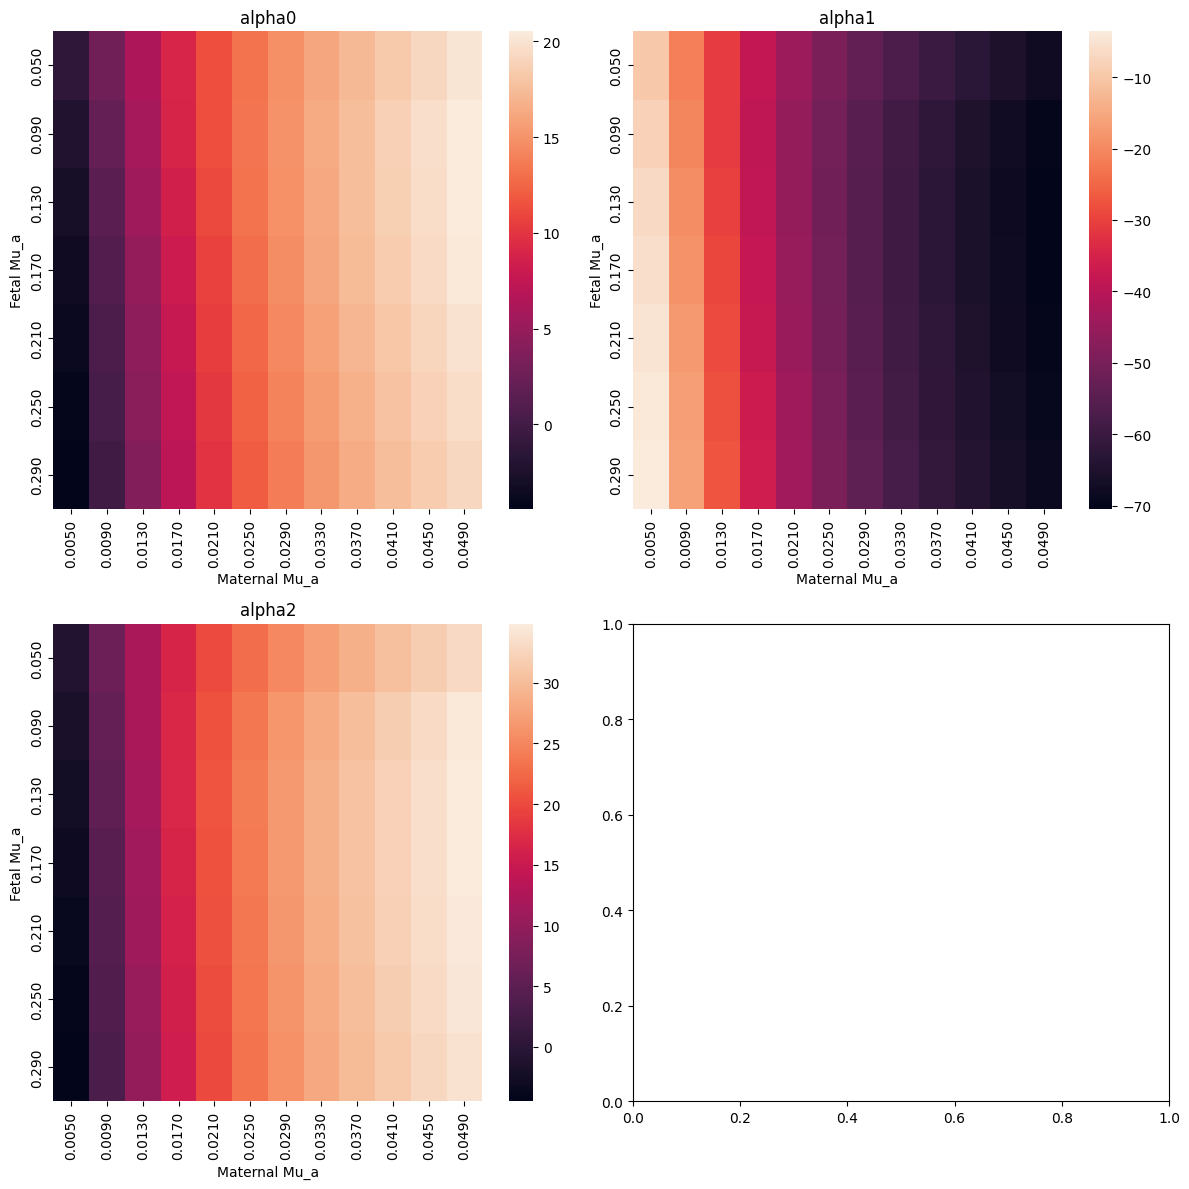

In [7]:
selected_data = fitting_param_table[(fitting_param_table['Wave Int'] == 1.0) & (fitting_param_table['Maternal Wall Thickness'] == 12.0) & (fitting_param_table['Uterus Thickness'] == 5.0)]
fig, axes = plt.subplots(2, 2, figsize=(12, 12))


for index, ax in enumerate(axes.flatten()):
    if index < fitting_param_count:
        plt.sca(ax)
        heatmap = selected_data[['Fetal Mu_a', 'Maternal Mu_a', f'alpha{index}']].pivot('Fetal Mu_a', 'Maternal Mu_a', f'alpha{index}')
        sns.heatmap(heatmap, xticklabels=[f'{x:0.4f}' for x in heatmap.columns], yticklabels=[f'{x:0.3f}' for x in heatmap.index])
        ax.set_title(f'alpha{index}')
    # sns.lineplot(data=selected_data, x='Fetal Mu_a', y=f'alpha{index}', hue='Maternal Mu_a', marker="o")
plt.tight_layout()

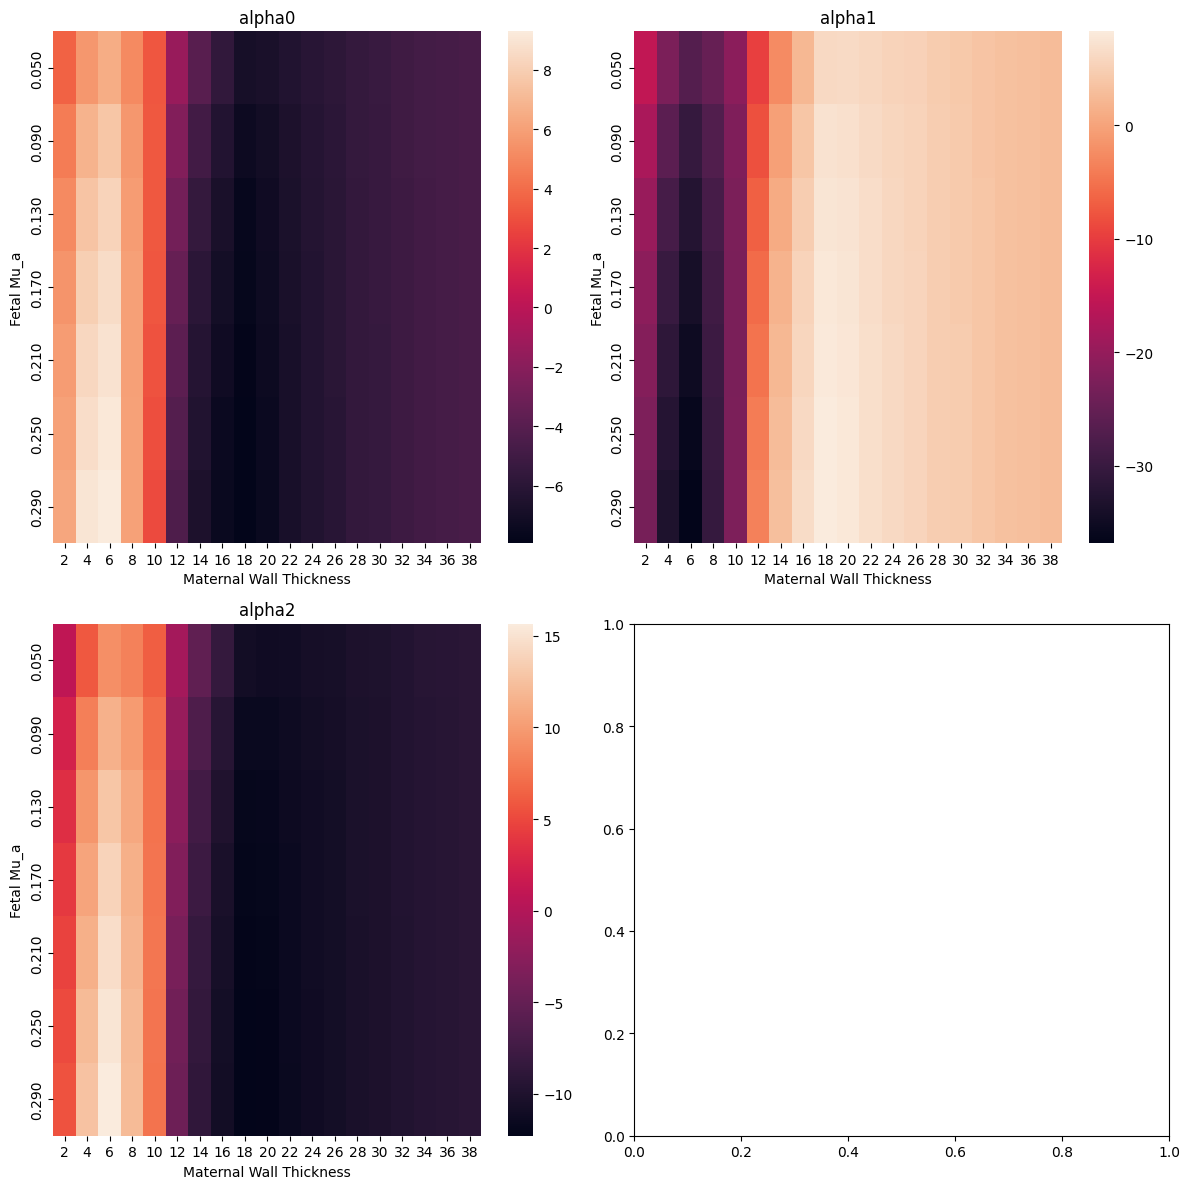

In [8]:
selected_data = fitting_param_table[(fitting_param_table['Wave Int'] == 1.0) & (fitting_param_table['Uterus Thickness'] == 5.0) & (fitting_param_table['Maternal Mu_a'] == 0.005)]
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

for index, ax in enumerate(axes.flatten()):
    if index < fitting_param_count:
        plt.sca(ax)
        heatmap = selected_data[['Fetal Mu_a', 'Maternal Wall Thickness', f'alpha{index}']].pivot('Fetal Mu_a', 'Maternal Wall Thickness', f'alpha{index}')
        sns.heatmap(heatmap, xticklabels=[f'{x:0.0f}' for x in heatmap.columns], yticklabels=[f'{x:0.3f}' for x in heatmap.index])
        ax.set_title(f'alpha{index}')
        # sns.lineplot(data=selected_data, x='Fetal Mu_a', y=f'alpha{index}', hue='Maternal Mu_a', marker="o")
plt.tight_layout()

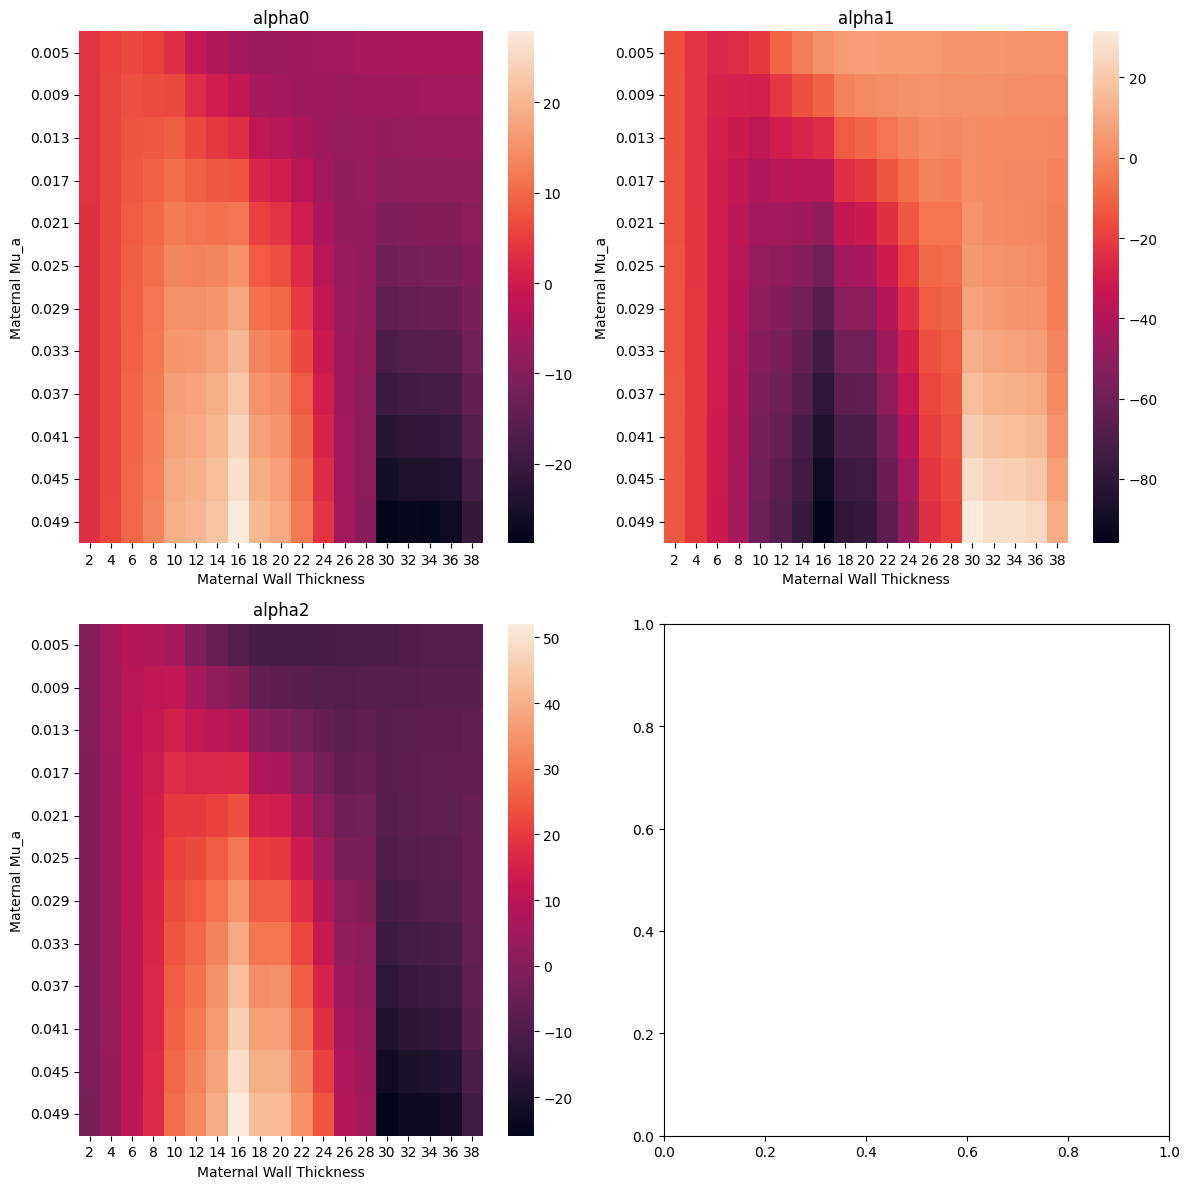

In [9]:
selected_data = fitting_param_table[(fitting_param_table['Wave Int'] == 1.0) & (fitting_param_table['Uterus Thickness'] == 5.0) & (fitting_param_table['Fetal Mu_a'] == 0.05)]
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

for index, ax in enumerate(axes.flatten()):
    if index < fitting_param_count:
        plt.sca(ax)
        heatmap = selected_data[['Maternal Mu_a', 'Maternal Wall Thickness', f'alpha{index}']].pivot('Maternal Mu_a', 'Maternal Wall Thickness', f'alpha{index}')
        sns.heatmap(heatmap, xticklabels=[f'{x:0.0f}' for x in heatmap.columns], yticklabels=[f'{x:0.3f}' for x in heatmap.index])
        ax.set_title(f'alpha{index}')
        # sns.lineplot(data=selected_data, x='Fetal Mu_a', y=f'alpha{index}', hue='Maternal Mu_a', marker="o")
plt.tight_layout()

# Changes in Fitting Parameter with Degrees of Freedom(Wavelength 2)

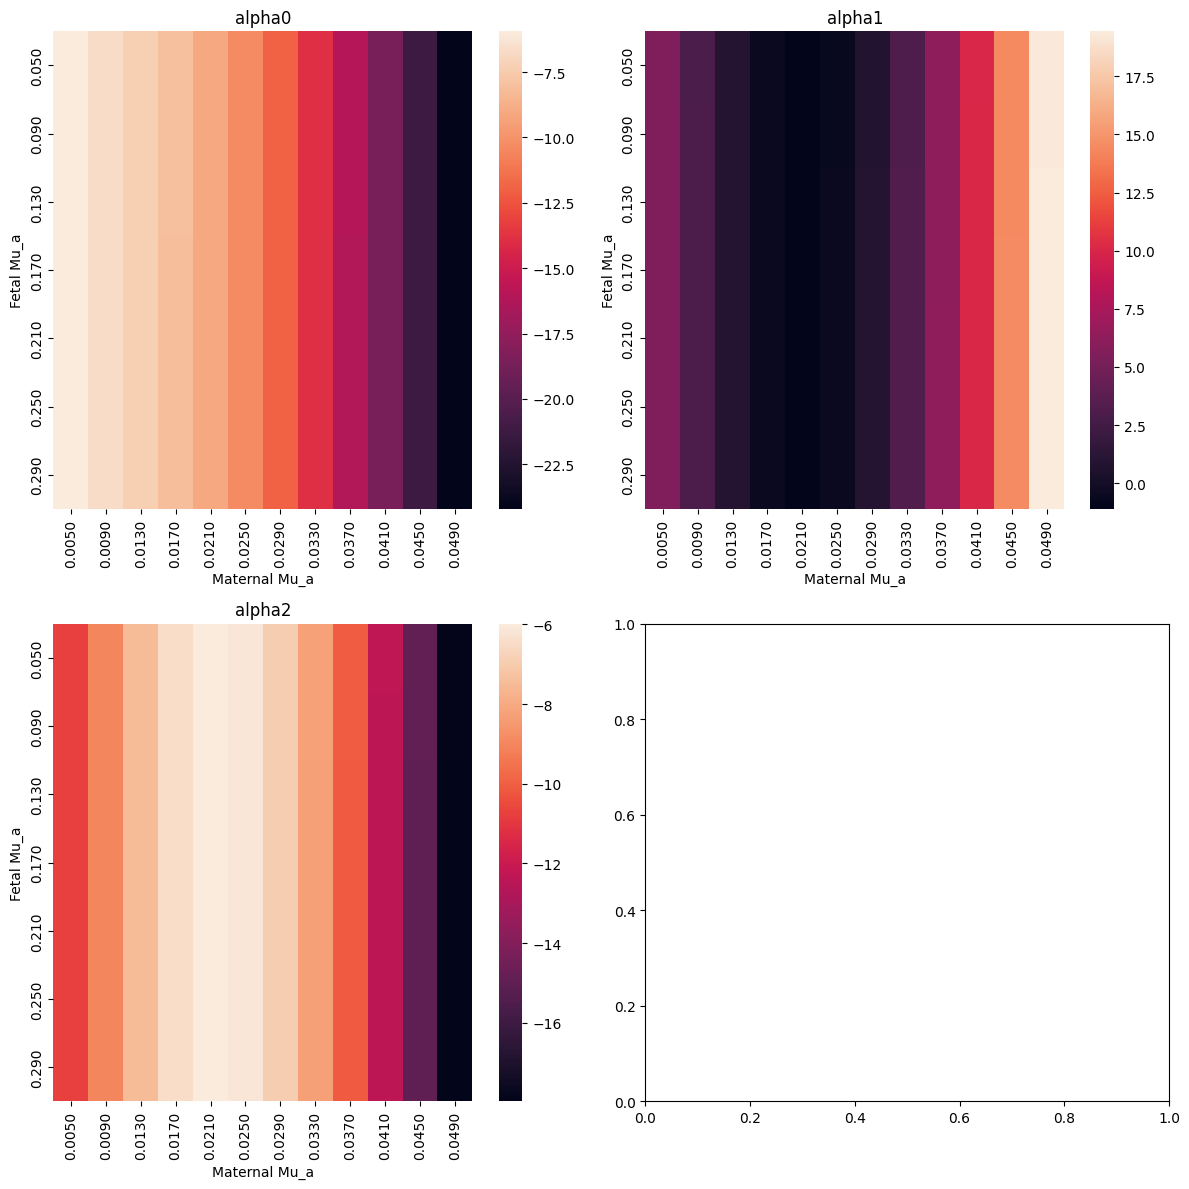

In [10]:
selected_data = fitting_param_table[(fitting_param_table['Wave Int'] == 2.0) & (fitting_param_table['Maternal Wall Thickness'] == 28.0) & (fitting_param_table['Uterus Thickness'] == 5.0)]
fig, axes = plt.subplots(2, 2, figsize=(12, 12))


for index, ax in enumerate(axes.flatten()):
    if index < fitting_param_count:
        plt.sca(ax)
        heatmap = selected_data[['Fetal Mu_a', 'Maternal Mu_a', f'alpha{index}']].pivot('Fetal Mu_a', 'Maternal Mu_a', f'alpha{index}')
        sns.heatmap(heatmap, xticklabels=[f'{x:0.4f}' for x in heatmap.columns], yticklabels=[f'{x:0.3f}' for x in heatmap.index])
        ax.set_title(f'alpha{index}')
        # sns.lineplot(data=selected_data, x='Fetal Mu_a', y=f'alpha{index}', hue='Maternal Mu_a', marker="o")
plt.tight_layout()

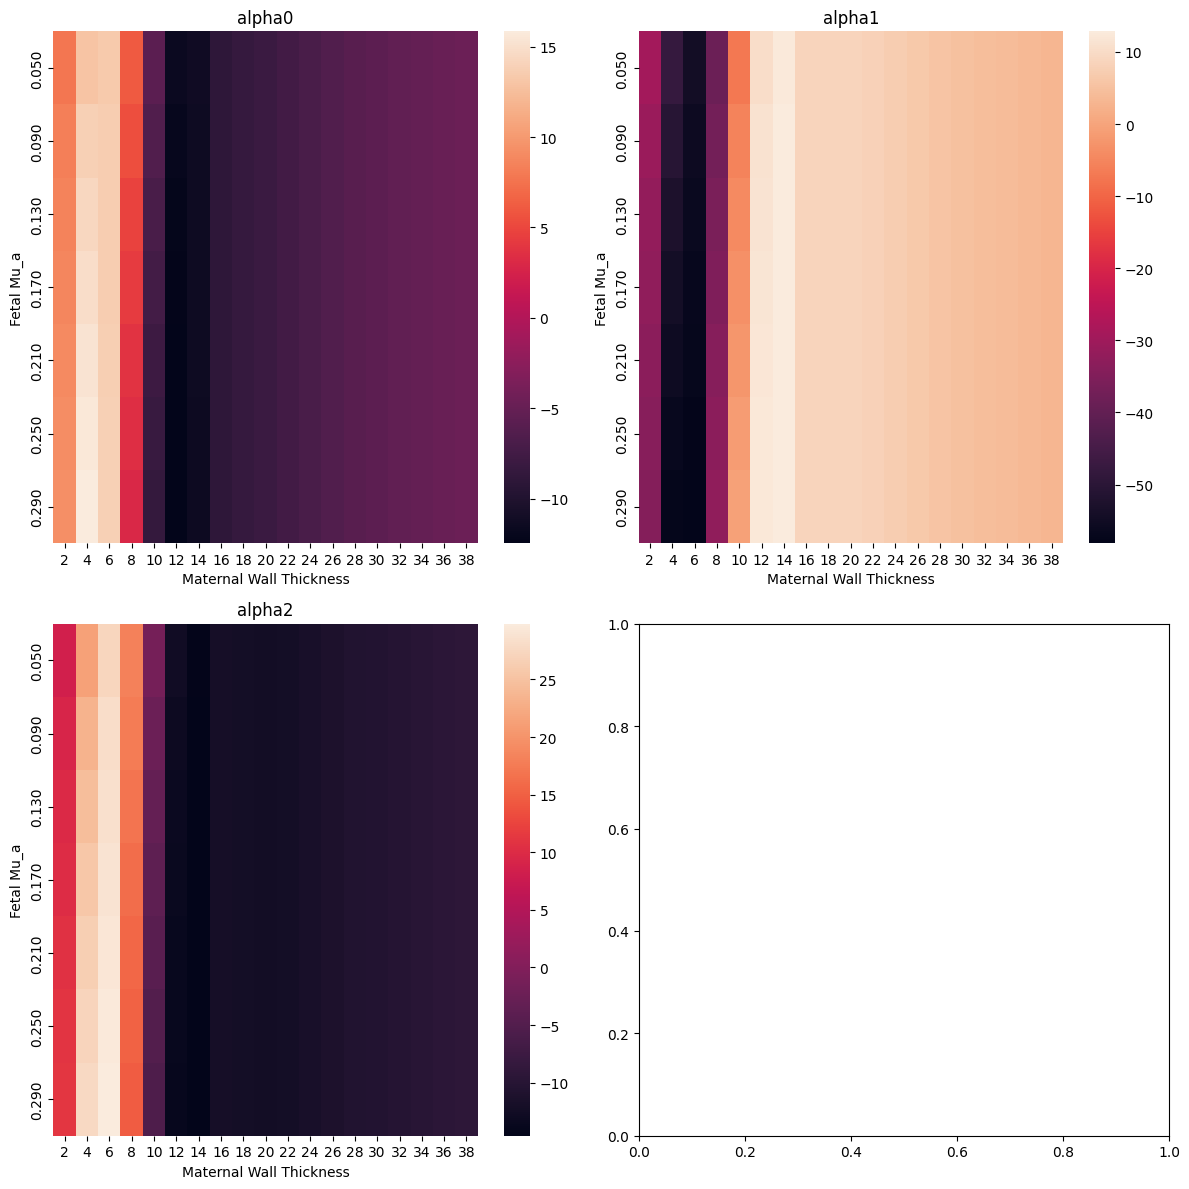

In [11]:
selected_data = fitting_param_table[(fitting_param_table['Wave Int'] == 2.0) & (fitting_param_table['Uterus Thickness'] == 5.0) & (fitting_param_table['Maternal Mu_a'] == 0.005)]
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

for index, ax in enumerate(axes.flatten()):
    if index < fitting_param_count:
        plt.sca(ax)
        heatmap = selected_data[['Fetal Mu_a', 'Maternal Wall Thickness', f'alpha{index}']].pivot('Fetal Mu_a', 'Maternal Wall Thickness', f'alpha{index}')
        sns.heatmap(heatmap, xticklabels=[f'{x:0.0f}' for x in heatmap.columns], yticklabels=[f'{x:0.3f}' for x in heatmap.index])
        ax.set_title(f'alpha{index}')
        # sns.lineplot(data=selected_data, x='Fetal Mu_a', y=f'alpha{index}', hue='Maternal Mu_a', marker="o")
plt.tight_layout()

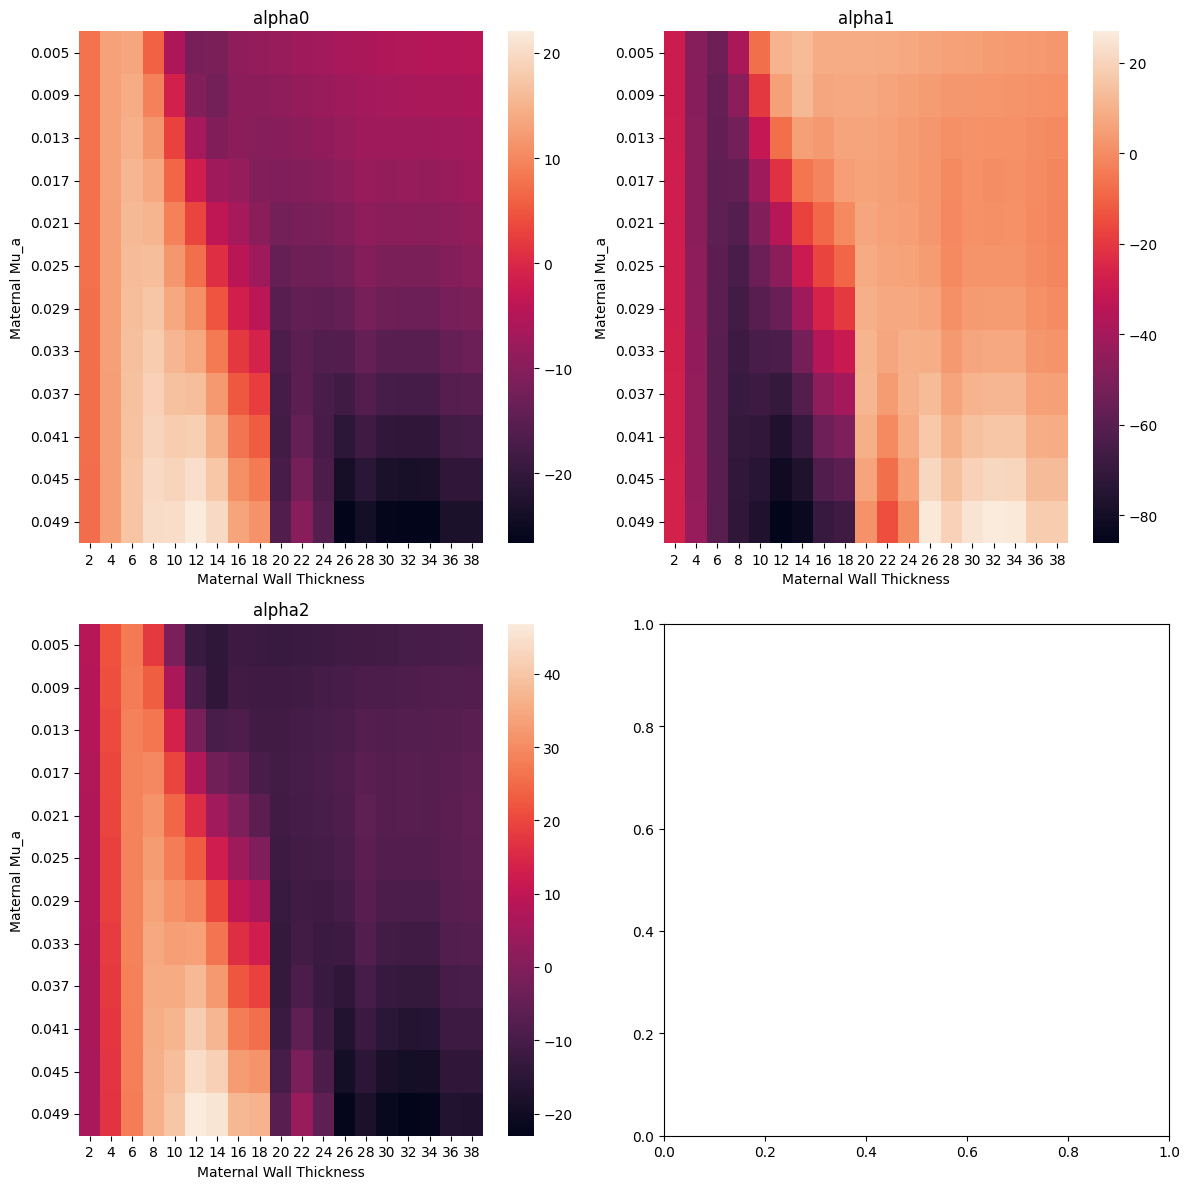

In [12]:
selected_data = fitting_param_table[(fitting_param_table['Wave Int'] == 2.0) & (fitting_param_table['Uterus Thickness'] == 5.0) & (fitting_param_table['Fetal Mu_a'] == 0.05)]
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

for index, ax in enumerate(axes.flatten()):
    if index < fitting_param_count:
        plt.sca(ax)
        heatmap = selected_data[['Maternal Mu_a', 'Maternal Wall Thickness', f'alpha{index}']].pivot('Maternal Mu_a', 'Maternal Wall Thickness', f'alpha{index}')
        sns.heatmap(heatmap, xticklabels=[f'{x:0.0f}' for x in heatmap.columns], yticklabels=[f'{x:0.3f}' for x in heatmap.index])
        ax.set_title(f'alpha{index}')
        # sns.lineplot(data=selected_data, x='Fetal Mu_a', y=f'alpha{index}', hue='Maternal Mu_a', marker="o")
plt.tight_layout()